In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.ensemble import StackingClassifier

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('data_insolvency.csv')

In [3]:
data.tail()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
6814,0,0.493687,0.539468,0.543230,0.604455,0.604462,0.998992,0.797409,0.809331,0.303510,...,0.799927,0.000466,0.623620,0.604455,0.840359,0.279606,0.027064,0.566193,1,0.029890
6815,0,0.475162,0.538269,0.524172,0.598308,0.598308,0.998992,0.797414,0.809327,0.303520,...,0.799748,0.001959,0.623931,0.598306,0.840306,0.278132,0.027009,0.566018,1,0.038284
6816,0,0.472725,0.533744,0.520638,0.610444,0.610213,0.998984,0.797401,0.809317,0.303512,...,0.797778,0.002840,0.624156,0.610441,0.840138,0.275789,0.026791,0.565158,1,0.097649
6817,0,0.506264,0.559911,0.554045,0.607850,0.607850,0.999074,0.797500,0.809399,0.303498,...,0.811808,0.002837,0.623957,0.607846,0.841084,0.277547,0.026822,0.565302,1,0.044009
6818,0,0.493053,0.570105,0.549548,0.627409,0.627409,0.998080,0.801987,0.813800,0.313415,...,0.815956,0.000707,0.626680,0.627408,0.841019,0.275114,0.026793,0.565167,1,0.233902


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

In [ ]:
# Check for missing values
na_df = data.isna().sum()
na_df[na_df > 0]

Series([], dtype: int64)

In [ ]:
# We might consider SMOTE later as data is imbalanced
data['Bankrupt?'].value_counts()

Bankrupt?
0    6599
1     220
Name: count, dtype: int64

# Feature Selection
## Remove unnecessary features with Filter Methods (based on the variance thershold, correlation with target, ANOVA and collinearity).

In [165]:
# We split the data first in order to avoid data leakage
X = data.drop('Bankrupt?', axis=1)
y = data['Bankrupt?']
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val,y_val, test_size=0.5, random_state=42)

In [176]:
# the split reserves imbablance
y_train.value_counts() / len(y_train), y_val.value_counts() / len(y_val), y_test.value_counts() / len(y_test)

(Bankrupt?
 0    0.970249
 1    0.029751
 Name: count, dtype: float64,
 Bankrupt?
 0    0.961877
 1    0.038123
 Name: count, dtype: float64,
 Bankrupt?
 0    0.961877
 1    0.038123
 Name: count, dtype: float64)

In [166]:
# Because there are so many features, we will first drop features that are nearly constant
sel = VarianceThreshold(threshold=0.0001)
sel.fit(X_train)
print(f"The percentage of features dropped: {(X_train.shape[1] - sum(sel.get_support()))/X_train.shape[1]*100:.2f}%")
non_quasi_constant_col = [x for x in X_train.columns if x in X_train.columns[sel.get_support()]]

The percentage of features dropped: 8.42%


In [167]:
# Drop features based on low correlation and ANOVA
corr_df = data.loc[X_train.index, ['Bankrupt?'] + non_quasi_constant_col].corr()
corr_target = corr_df['Bankrupt?'].abs().sort_values(ascending=False)
least_corr_col = corr_target[corr_target < 0.005].index.to_list()
fvalue_selector = SelectKBest(f_classif, k=50)
fvalue_selector.fit_transform(X_train, y_train)
drop_col = list(set(least_corr_col) - set(X_train.columns[fvalue_selector.get_support()].to_list()))
print(f"We will drop {len(drop_col)} features based on their low correlation with target and ANOVA.")

We will drop 10 features based on their low correlation with target and ANOVA.


In [184]:
# Drop features based on collinearity
high_corr_col = []
corr_df = data.loc[X_train.index, :].corr()
for c in corr_df.columns[1:]:
    if c in high_corr_col:
        continue
    this_corr = corr_df.drop(['Bankrupt?', c], axis=1).loc[c,:].copy()
    if len(this_corr[abs(this_corr)>=0.99]) > 0:
        # high_corr_col.append(c)
        high_corr_col.extend(this_corr[abs(this_corr)>=0.99].index.to_list())
high_corr_col = list(set(high_corr_col))
print(f"We will also drop {len(high_corr_col)} features because they are highly correlated with each other.")

We will also drop 11 features because they are highly correlated with each other.


We keep 68 features after removing quasi-constant and least correlated features and anova selection


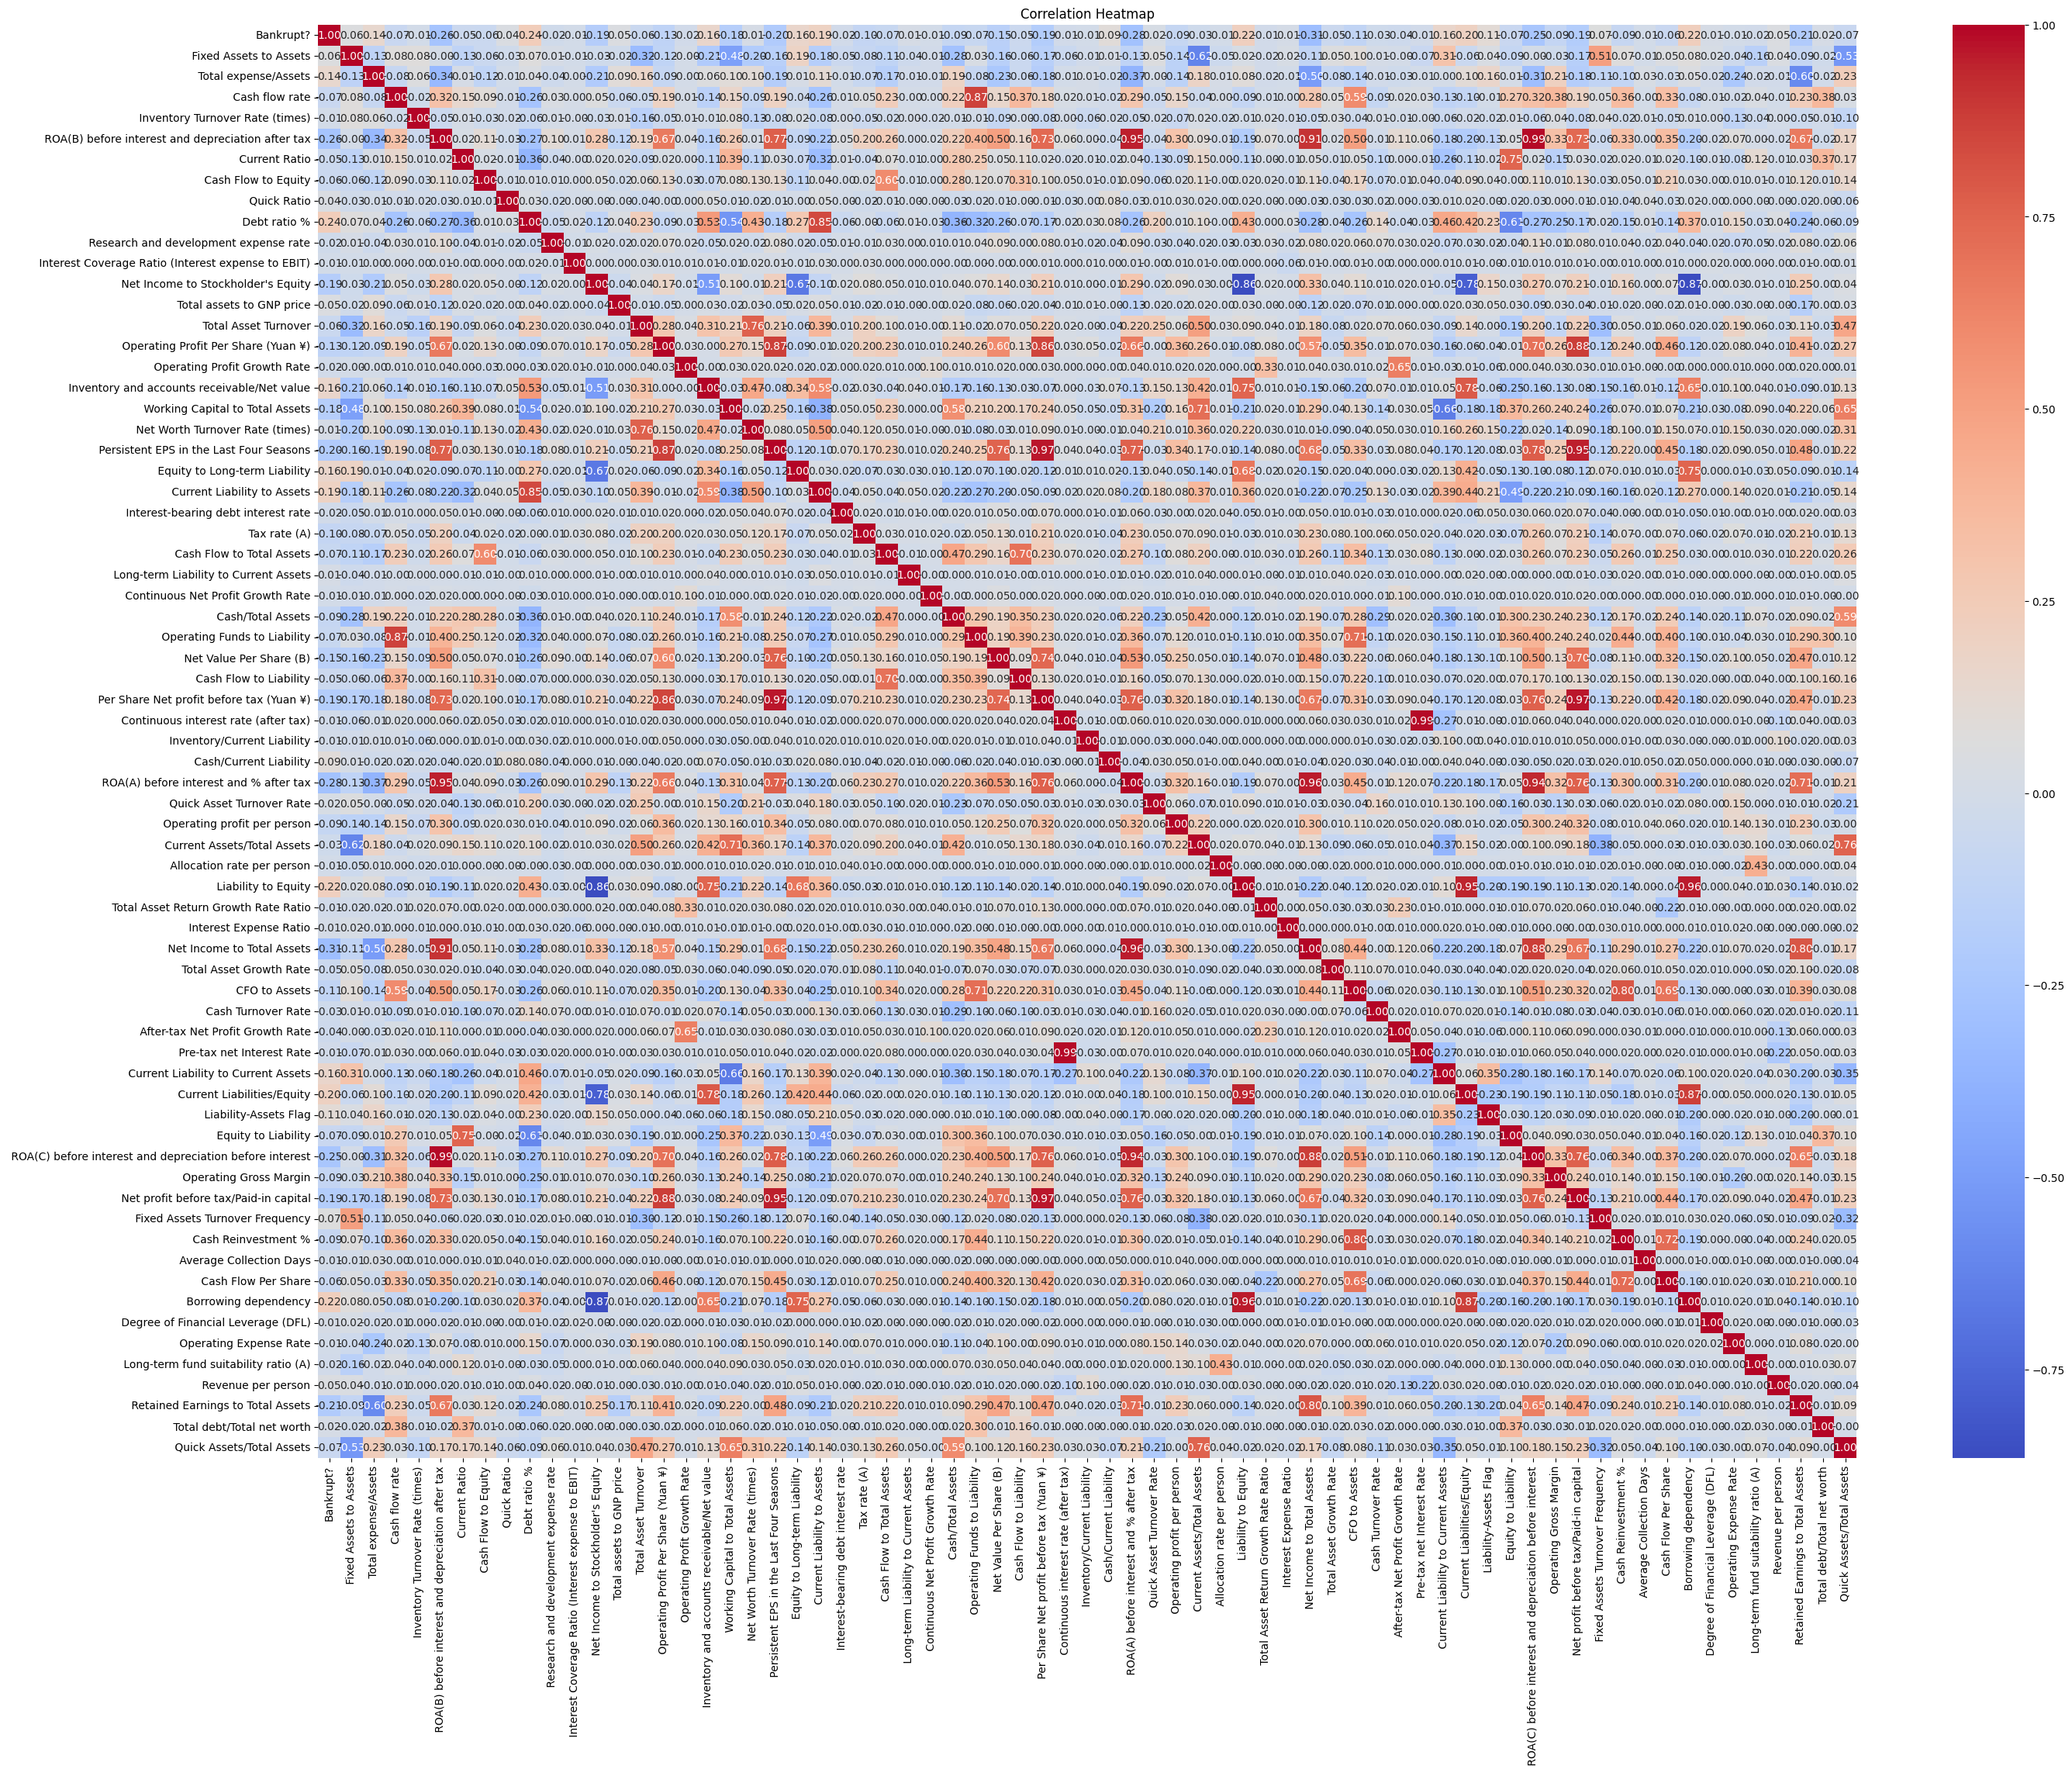

'\nConclusions:\n- Collinearity exists among some features, might consider droppigng some of them\n- There are also some features that have very low correlation with the target variable\n'

In [ ]:
retain_col = list(set(non_quasi_constant_col) - set(drop_col) - set(high_corr_col))
print(f"We keep {len(retain_col)} features after removing quasi-constant and least correlated features and anova selection")
corr_df = data.loc[X_train.index, ['Bankrupt?'] + retain_col].corr()
plt.figure(figsize=(32, 24))
sns.heatmap(corr_df, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()
plt.savefig('correlation_heatmap.png', dpi = 300)
plt.close()
'''
Conclusions:
- Collinearity exists among some features, might consider droppigng some of them
- There are also some features that have very low correlation with the target variable
b'''

# Model Selection
## Step 1: Baseline Model: XGBoost

In [204]:
xgb = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)

X = data[retain_col].copy()
y = data['Bankrupt?']
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val,y_val, test_size=0.5, random_state=42)

xgb.fit(X_train, y_train)
y_train_pred = xgb.predict(X_train)
y_val_pred = xgb.predict(X_val)

print(classification_report(y_train, y_train_pred))
print(classification_report(y_val, y_val_pred))


              precision    recall  f1-score   support

           0       0.99      1.00      1.00      4631
           1       0.99      0.75      0.85       142

    accuracy                           0.99      4773
   macro avg       0.99      0.87      0.92      4773
weighted avg       0.99      0.99      0.99      4773

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       984
           1       0.56      0.26      0.35        39

    accuracy                           0.96      1023
   macro avg       0.76      0.62      0.67      1023
weighted avg       0.96      0.96      0.96      1023



In [189]:
'''
Conclusions:
- There's very slight overfitting in the baseline model.
- It doesn't predict well for class1 because of the target imbalance.
'''

"\nConclusions:\n- There's very slight overfitting in the baseline model.\n- It doesn't predict well for class1 because of the target imbalance.\n"

## Step 2: SMOTE


In [210]:
sm = SMOTE(k_neighbors=5, random_state=42)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)

xgb = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)

xgb.fit(X_train_smote, y_train_smote)
y_train_pred = xgb.predict(X_train_smote)
y_val_pred = xgb.predict(X_val)

print(classification_report(y_train_smote, y_train_pred))
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98      4631
           1       0.97      1.00      0.98      4631

    accuracy                           0.98      9262
   macro avg       0.98      0.98      0.98      9262
weighted avg       0.98      0.98      0.98      9262

              precision    recall  f1-score   support

           0       0.99      0.96      0.97       984
           1       0.37      0.67      0.48        39

    accuracy                           0.94      1023
   macro avg       0.68      0.81      0.72      1023
weighted avg       0.96      0.94      0.95      1023



In [196]:
'''
Conclusions:
- Slight improvement only.
'''

'\nConclusions:\n- Slight improvement only.\n'

## Step 3: Pipeline with preprocessing, a few models and GridSearch

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [207]:
# sm = SMOTE(k_neighbors=5, random_state=42)
# X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression())  # placeholder
])

param_grid = [
    {
        'classifier': [LogisticRegression(max_iter=1000)],
        'classifier__C': [0.1, 1, 5, 10]
    },
    {
        'classifier': [SVC()],
        'classifier__C': [0.1, 0.5, 1, 5],
        'classifier__kernel': ['linear', 'rbf']
    },
    {
        'classifier': [KNeighborsClassifier()],
        'classifier__n_neighbors': [3, 5, 7, 9, 11]
    },
    {
        'classifier': [RandomForestClassifier()],
        'classifier__n_estimators': [100, 200, 300],
        'classifier__max_depth': [None, 3, 5, 7, 9]
    },
    {
        'classifier': [GradientBoostingClassifier()],
        'classifier__n_estimators': [100, 200, 300],
        'classifier__learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25]
    },
    {
        'classifier': [XGBClassifier(use_label_encoder=False, eval_metric='logloss')],
        'classifier__n_estimators': [100, 200, 300],
        'classifier__learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25],
        'classifier__max_depth': [3, 5, 5, 7, 9]
    }
]

grid = GridSearchCV(pipe, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid.fit(X_train_smote, y_train_smote)

# Step 6: Evaluate best model
print("Best Model:", type(grid.best_estimator_.named_steps['classifier']).__name__)
print("Best Parameters:", grid.best_params_)
print("Best CV Score:", grid.best_score_)
print("Test Report:\n", classification_report(y_val, grid.predict(X_val)))

Best Model: XGBClassifier
Best Parameters: {'classifier': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...), 'classifier__learning_rate': 0.1, 'classifier__max_depth': 7, 'classifier__n_estimators': 200}
Best CV Score: 0.9876076897394146
Test Report:
               prec

Best model is XGBClassifier, with learning_rate 0.1, max_depth 7, and n_estimators 200.

## Step 4: Revisit Feature Selection

Optimal number of features: 62
Selected features mask: [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True False  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True False  True  True
  True  True  True False  True  True  True  True  True False  True  True
  True  True False False  True  True  True  True]
Feature ranking: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 2 1 1 1 1 1 7 1 1 1 1 1 6 1 1 1 1 3 5 1 1 1 1]


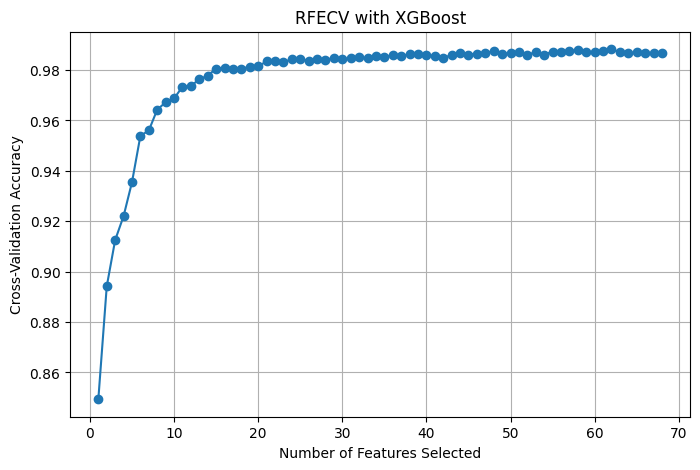

In [ ]:
xgb = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=7,
    eval_metric='mlogloss',
    random_state=42
)

rfecv = RFECV(
    estimator=xgb,
    step=1,
    cv=StratifiedKFold(5),
    scoring='f1',
    n_jobs=-1
)

rfecv.fit(X_train_smote, y_train_smote)
sel_feature = X_train.columns[rfecv.support_].to_list()

print("Optimal number of features:", rfecv.n_features_)
print("Selected features mask:", rfecv.support_)
print("Feature ranking:", rfecv.ranking_)
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'], marker='o')
plt.xlabel("Number of Features Selected")
plt.ylabel("Cross-Validation Accuracy")
plt.title("RFECV with XGBoost")
plt.grid(True)
plt.show()

In [226]:
import pickle
with open('selected_features.pkl', 'wb') as f:
    pickle.dump(sel_feature, f)

In [244]:
X = data[sel_feature].copy()
y = data['Bankrupt?']

X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val,y_val, test_size=0.5, random_state=42)

sm = SMOTE(k_neighbors=5, random_state=42)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)

xgb = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=7,
    eval_metric='mlogloss',
    random_state=42
)

xgb.fit(X_train_smote, y_train_smote)
y_train_pred = xgb.predict(X_train_smote)
y_val_pred = xgb.predict(X_val)

print(classification_report(y_train_smote, y_train_pred))
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4631
           1       1.00      1.00      1.00      4631

    accuracy                           1.00      9262
   macro avg       1.00      1.00      1.00      9262
weighted avg       1.00      1.00      1.00      9262

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       984
           1       0.59      0.56      0.58        39

    accuracy                           0.97      1023
   macro avg       0.79      0.77      0.78      1023
weighted avg       0.97      0.97      0.97      1023



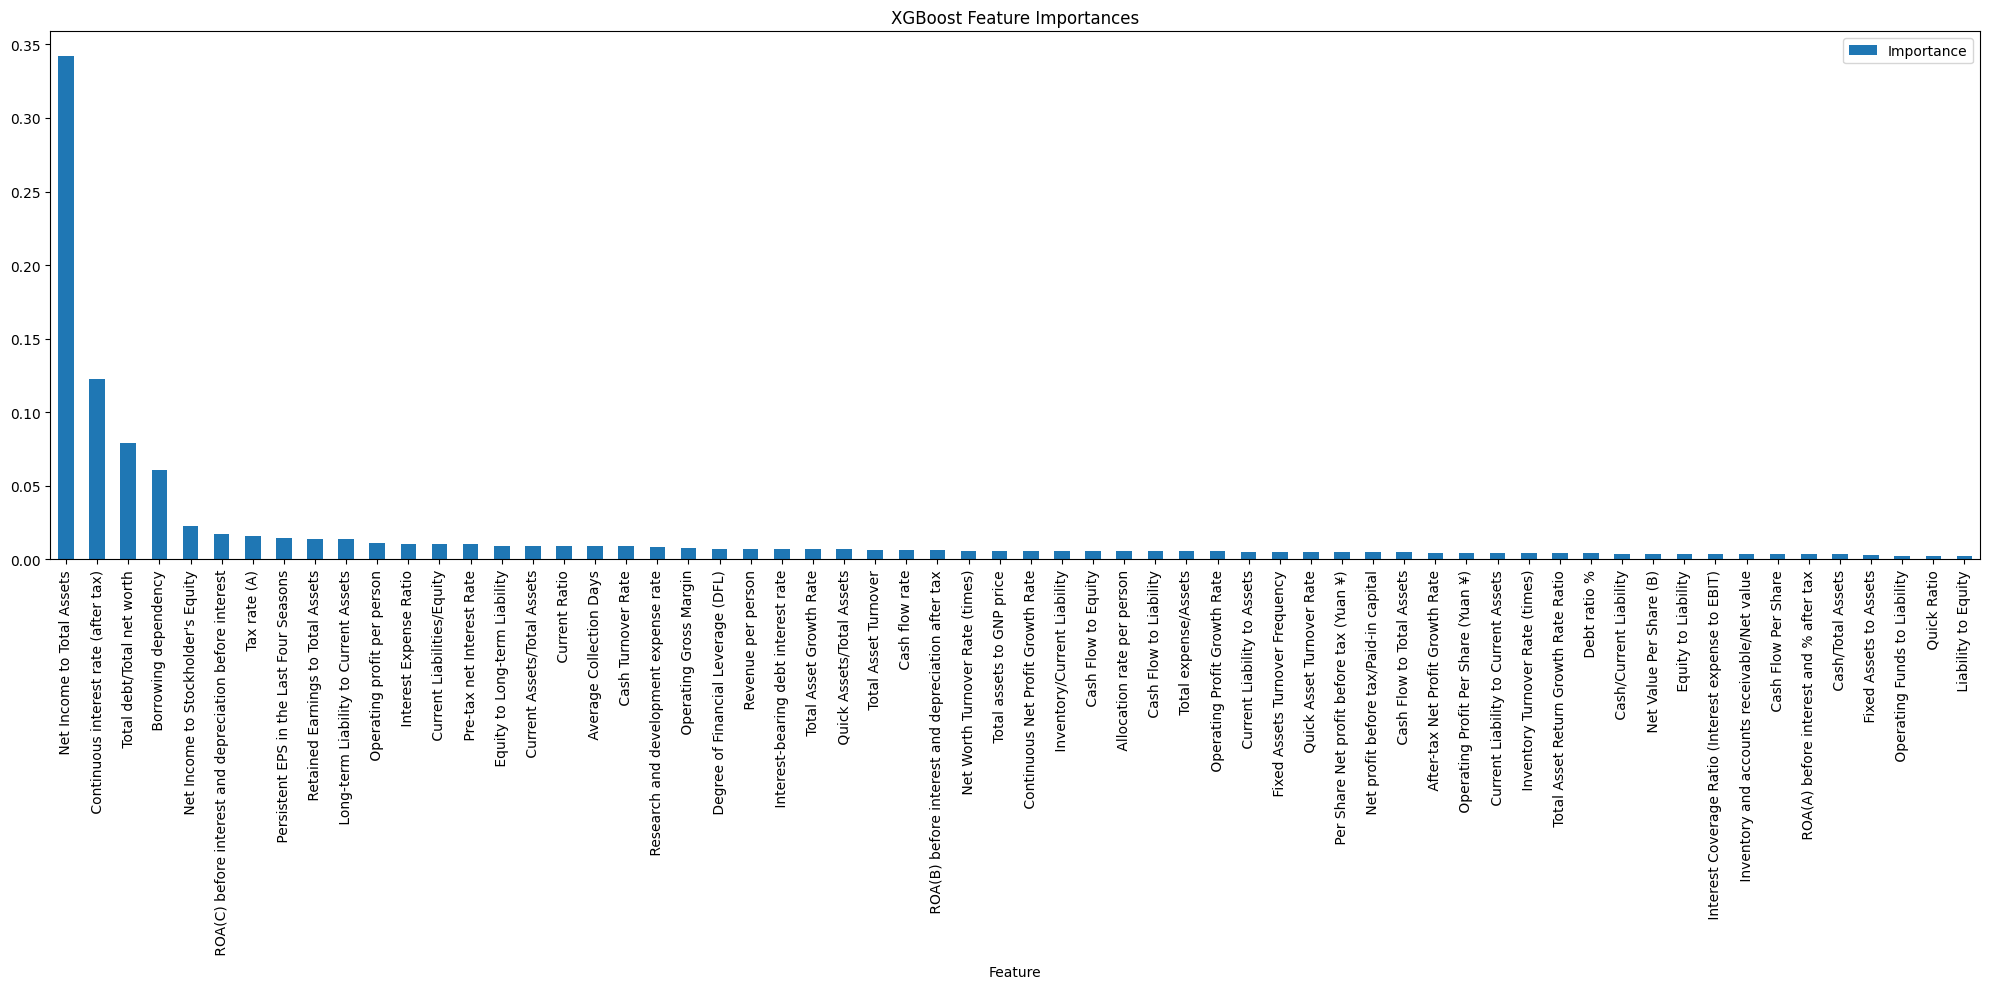

In [242]:
importances = xgb.feature_importances_
feature_names = X_train_smote.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df.sort_values(by='Importance', ascending=False, inplace=True)
# Plot
importance_df.plot.bar(x='Feature', y='Importance', figsize=(20, 10))
plt.title("XGBoost Feature Importances")
plt.tight_layout()
plt.show()

imp_feature = importance_df[importance_df['Importance']>0.01]['Feature'].to_list()
with open('important_features.pkl', 'wb') as f:
    pickle.dump(imp_feature, f)


# Stacking

In [ ]:
estimators = [
    ("rf", RandomForestClassifier(random_state = 42, class_weight="balanced_subsample")),
    ("gb", GradientBoostingClassifier(random_state = 42)),
    ("xgb", xgb)
]
clf = StackingClassifier(estimators=estimators, final_estimator = RandomForestClassifier(random_state=42), cv=5)
clf.fit(X_train_smote, y_train_smote)
y_train_pred = clf.predict(X_train_smote)
y_val_pred = clf.predict(X_val)

print(classification_report(y_train_smote, y_train_pred))
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4631
           1       1.00      1.00      1.00      4631

    accuracy                           1.00      9262
   macro avg       1.00      1.00      1.00      9262
weighted avg       1.00      1.00      1.00      9262

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       984
           1       0.67      0.26      0.37        39

    accuracy                           0.97      1023
   macro avg       0.82      0.63      0.68      1023
weighted avg       0.96      0.97      0.96      1023



# Evaluate Performance on Test Set

In [250]:
X = data[sel_feature].copy()
y = data['Bankrupt?']

X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val,y_val, test_size=0.5, random_state=42)

sm = SMOTE(k_neighbors=5, random_state=42)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)

xgb = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=7,
    eval_metric='mlogloss',
    random_state=42
)

xgb.fit(X_train_smote, y_train_smote)
y_train_pred = xgb.predict(X_train_smote)
y_val_pred = xgb.predict(X_val)
y_test_pred = xgb.predict(X_test)

print(classification_report(y_train_smote, y_train_pred))
print(classification_report(y_val, y_val_pred))
print(classification_report(y_test, y_test_pred))

with open('xgb_model.pkl', 'wb') as f:
    pickle.dump(xgb, f)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4631
           1       1.00      1.00      1.00      4631

    accuracy                           1.00      9262
   macro avg       1.00      1.00      1.00      9262
weighted avg       1.00      1.00      1.00      9262

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       984
           1       0.59      0.56      0.58        39

    accuracy                           0.97      1023
   macro avg       0.79      0.77      0.78      1023
weighted avg       0.97      0.97      0.97      1023

              precision    recall  f1-score   support

           0       0.98      0.97      0.98       984
           1       0.44      0.51      0.48        39

    accuracy                           0.96      1023
   macro avg       0.71      0.74      0.73      1023
weighted avg       0.96      0.96      0.96      1023



In [252]:
X = data[imp_feature].copy()
y = data['Bankrupt?']

X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val,y_val, test_size=0.5, random_state=42)

sm = SMOTE(k_neighbors=5, random_state=42)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)

xgb_imp = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=7,
    eval_metric='mlogloss',
    random_state=42
)

xgb_imp.fit(X_train_smote, y_train_smote)
y_train_pred = xgb_imp.predict(X_train_smote)
y_val_pred = xgb_imp.predict(X_val)
y_test_pred = xgb_imp.predict(X_test)

print(classification_report(y_train_smote, y_train_pred))
print(classification_report(y_val, y_val_pred))
print(classification_report(y_test, y_test_pred))

with open('xgb_model_imp.pkl', 'wb') as f:
    pickle.dump(xgb_imp, f)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4631
           1       1.00      1.00      1.00      4631

    accuracy                           1.00      9262
   macro avg       1.00      1.00      1.00      9262
weighted avg       1.00      1.00      1.00      9262

              precision    recall  f1-score   support

           0       0.98      0.97      0.97       984
           1       0.39      0.56      0.46        39

    accuracy                           0.95      1023
   macro avg       0.69      0.76      0.72      1023
weighted avg       0.96      0.95      0.95      1023

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       984
           1       0.34      0.49      0.40        39

    accuracy                           0.94      1023
   macro avg       0.66      0.72      0.69      1023
weighted avg       0.95      0.94      0.95      1023



In [267]:
(data[imp_feature].max()*1.1)[imp_feature[0]]

np.float64(1.1)